### Assignment Ask
Refer to code from previos session WRITE IT AGAIN SUCH THAT IT ACHIEVES
- 99.4% validation accuracy
- Less than 20k Parameters
- Less than 20 Epochs
- Have used BN, Dropout,
(Optional): a Fully connected layer, have used GAP.



###  Key Results:
**Total Params: 19,458**

**Accuracy: 99.41%** (test set)

Key updates:
1. Reduced the batch size
2. Used GAP global average pool
3. Used dropout, best in this scenario is 0.08 and 0.10 much less than 25 percent
4. Used Batch normalisation


https://colab.research.google.com/drive/1j4193Iunq2quD6Iuma7g45QzFbLLNNBf#scrollTo=7Uk2RfZjfBOY

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

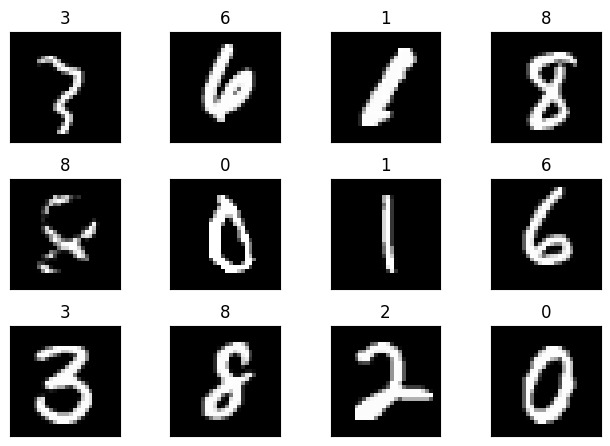

In [13]:
# torch.manual_seed(1)
batch_size = 32 # smaller the batch size better accuracy

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])



In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()



        self.conv1 = nn.Sequential(
            # s= 1, p =1, k = 3
            #nin = 28x28x1   #  nout = ((nin+2*p-k)/s)+1 = 28
            #jin = 1,  #  j_out = j_in * s = 1 * 1 = 1
            #rin = 1, rout = rin+(k-1)Jin =1+(3-1)*1 = 3
            nn.Conv2d(1, 16, 3, padding=1,bias= False),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            #s= 1, k = 3, p = 1
            #nin = 28x28x16  #  nout = ((nin+2*p-k)/s)+1 = 28 -1/1 + 1 = 28
            #jin = 1,  #  j_out = j_in * s = 1 * 1 = 1
            #rin = 3, rout = rin+(k-1)Jin = 3 +(3-1)* 1 = 5
            nn.Conv2d(16, 20, 3, padding=1, bias= False),
            nn.ReLU(),
            nn.BatchNorm2d(20),


            #s= 2, k = 2, p = 0
            #nin = 28x28x20   #  nout = ((nin+2*p-k)/s)+1 = 28 -2/ 2 + 1 = 14
            #jin = 1,  #  j_out = j_in * s = 1 * 2 = 2
            #rin = 5, rout = rin+(k-1)Jin = 5 +(2-1)* 1 = 6
            nn.MaxPool2d(2, 2),

            #s= 1, k = 3, p = 1
            #nin = 14x14x20   #  nout = ((nin+2*p-k)/s)+1 = 14 -1/1 +1 = 14
            #jin = 2,  #  j_out = j_in * s = 2 * 1 = 2
            #rin = 6, rout = rin+(k-1)Jin = 6 +(3-1)* 2 = 10
            nn.Conv2d(20, 20, 3, padding=1,bias= False),
            nn.ReLU(),
            nn.BatchNorm2d(20),
            nn.Dropout(0.09)
        )
        self.conv2 = nn.Sequential(

            #s= 2, k = 3, p = 1
            #nin = 14x14x20   #  nout = ((nin+2*p-k)/s)+1 = (14-1)/2 +1 = 7
            #jin = 2,  #  j_out = j_in * s = 2 * 2 = 4
            #rin = 10, rout = rin+(k-1)Jin = 10 +(3-1)*2 = 14
            nn.Conv2d(20, 24, 3, padding=1, stride=2, bias= False),
            nn.ReLU(),
            nn.BatchNorm2d(24),

            #nin = 8x8x24   #  nout = ((nin+2*p-k)/s)+1 = 8

            #s= 1, k = 3, p = 1
            #nin = 7x7X24   #  nout = ((nin+2*p-k)/s)+1 = (7-1)/2 +1 = 4
            #jin = 4,  #  j_out = j_in * s = 4 * 1 = 4
            #rin = 14, rout = rin+(k-1)Jin = 14 +(3-1)*4 = 22
            nn.Conv2d(24, 28, 3,padding=1, bias= False),
            nn.ReLU(),
            nn.BatchNorm2d(28),

            #s= 2, k = 2, p = 0
            #nin = 4x4X28   #  nout = ((nin+2*p-k)/s)+1 = (4-2)/2 +1 = 2
            #jin = 4,  #  j_out = j_in * s = 4 * 2 = 8
            #rin = 22, rout = rin+(k-1)Jin = 22 +(2-1)*4 = 26
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.08)
        )

        self.conv3 = nn.Sequential(

            #s= 1, k = 1, p = 1
            #nin = 2x2X28   #  nout = ((nin+2*p-k)/s)+1 = (2+1)/1 +1 = 4
            #jin = 8,  #  j_out = j_in * s = 8 * 1 = 8
            #rin = 26, rout = rin+(k-1)Jin = 26 +(0)*8 = 26
            nn.Conv2d(28, 32, 1, padding=1,bias= False ),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            #s= 2, k = 2, p = 0
            #nin = 4x4X32   #  nout = ((nin+2*p-k)/s)+1 = (4-2)/2 +1 = 2
            #jin = 8,  #  j_out = j_in * s = 8 * 2 = 10
            #rin = 26, rout = rin+(k-1)Jin = 26 +(1)*8 = 34
            nn.AvgPool2d(2,2),
            nn.Dropout(0.08)
        )

        self.fc = nn.Sequential(
            #params = nin * nin * channels = 2*2 32
            nn.Linear(128, 10)
        )


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [5]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
              ReLU-2           [-1, 16, 28, 28]               0
       BatchNorm2d-3           [-1, 16, 28, 28]              32
            Conv2d-4           [-1, 20, 28, 28]           2,880
              ReLU-5           [-1, 20, 28, 28]               0
       BatchNorm2d-6           [-1, 20, 28, 28]              40
         MaxPool2d-7           [-1, 20, 14, 14]               0
            Conv2d-8           [-1, 20, 14, 14]           3,600
              ReLU-9           [-1, 20, 14, 14]               0
      BatchNorm2d-10           [-1, 20, 14, 14]              40
          Dropout-11           [-1, 20, 14, 14]               0
           Conv2d-12             [-1, 24, 7, 7]           4,320
             ReLU-13             [-1, 24, 7, 7]               0
      BatchNorm2d-14             [-1, 2

In [6]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [17]:
batch_size = 32
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 20):
    print(f"Epoc {epoch}")
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Epoc 1


loss=0.0626017302274704 batch_id=1874: 100%|██████████| 1875/1875 [00:34<00:00, 54.34it/s]



Test set: Average loss: 0.0436, Accuracy: 9861/10000 (98.6100%)

Epoc 2


loss=0.02758871577680111 batch_id=1874: 100%|██████████| 1875/1875 [00:34<00:00, 54.70it/s]



Test set: Average loss: 0.0301, Accuracy: 9896/10000 (98.9600%)

Epoc 3


loss=0.01664341427385807 batch_id=1874: 100%|██████████| 1875/1875 [00:34<00:00, 54.22it/s]



Test set: Average loss: 0.0296, Accuracy: 9899/10000 (98.9900%)

Epoc 4


loss=0.0021542678587138653 batch_id=1874: 100%|██████████| 1875/1875 [00:36<00:00, 51.39it/s]



Test set: Average loss: 0.0254, Accuracy: 9914/10000 (99.1400%)

Epoc 5


loss=0.08347930759191513 batch_id=1874: 100%|██████████| 1875/1875 [00:35<00:00, 52.69it/s]



Test set: Average loss: 0.0221, Accuracy: 9924/10000 (99.2400%)

Epoc 6


loss=0.02236880734562874 batch_id=1874: 100%|██████████| 1875/1875 [00:35<00:00, 53.42it/s]



Test set: Average loss: 0.0230, Accuracy: 9915/10000 (99.1500%)

Epoc 7


loss=0.050502412021160126 batch_id=1874: 100%|██████████| 1875/1875 [00:34<00:00, 53.88it/s]



Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.3400%)

Epoc 8


loss=0.012287985533475876 batch_id=1874: 100%|██████████| 1875/1875 [00:34<00:00, 54.36it/s]



Test set: Average loss: 0.0199, Accuracy: 9929/10000 (99.2900%)

Epoc 9


loss=0.02428797259926796 batch_id=1874: 100%|██████████| 1875/1875 [00:34<00:00, 54.17it/s]



Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.3200%)

Epoc 10


loss=0.013243856839835644 batch_id=1874: 100%|██████████| 1875/1875 [00:33<00:00, 55.64it/s]



Test set: Average loss: 0.0201, Accuracy: 9927/10000 (99.2700%)

Epoc 11


loss=0.006148474290966988 batch_id=1874: 100%|██████████| 1875/1875 [00:33<00:00, 55.36it/s]



Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99.2700%)

Epoc 12


loss=0.015400918200612068 batch_id=1874: 100%|██████████| 1875/1875 [00:33<00:00, 55.42it/s]



Test set: Average loss: 0.0170, Accuracy: 9942/10000 (99.4200%)

Epoc 13


loss=0.000800441310275346 batch_id=1874: 100%|██████████| 1875/1875 [00:33<00:00, 55.83it/s]



Test set: Average loss: 0.0196, Accuracy: 9929/10000 (99.2900%)

Epoc 14


loss=0.027138588950037956 batch_id=1874: 100%|██████████| 1875/1875 [00:34<00:00, 54.49it/s]



Test set: Average loss: 0.0199, Accuracy: 9932/10000 (99.3200%)

Epoc 15


loss=0.0014842605451121926 batch_id=1874: 100%|██████████| 1875/1875 [00:35<00:00, 53.42it/s]



Test set: Average loss: 0.0190, Accuracy: 9932/10000 (99.3200%)

Epoc 16


loss=0.0017839813372120261 batch_id=1874: 100%|██████████| 1875/1875 [00:34<00:00, 53.79it/s]



Test set: Average loss: 0.0211, Accuracy: 9933/10000 (99.3300%)

Epoc 17


loss=0.009954585693776608 batch_id=1874: 100%|██████████| 1875/1875 [00:35<00:00, 53.07it/s]



Test set: Average loss: 0.0201, Accuracy: 9927/10000 (99.2700%)

Epoc 18


loss=0.0018108835211023688 batch_id=1874: 100%|██████████| 1875/1875 [00:35<00:00, 52.13it/s]



Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.2700%)

Epoc 19


loss=0.0005376689950935543 batch_id=1874: 100%|██████████| 1875/1875 [00:35<00:00, 52.13it/s]



Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.4100%)

